## 1.0 Import Data

In [69]:
#from kaggle.api.kaggle_api_extended import KaggleApi
import pandas as pd
import matplotlib.pyplot as plt

#api = KaggleApi()
#api.authenticate()

#dataset_name = "sbhatti/financial-sentiment-analysis"
#api.dataset_download_files(dataset_name, path="./", unzip=True)

df = pd.read_csv("data.csv")
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


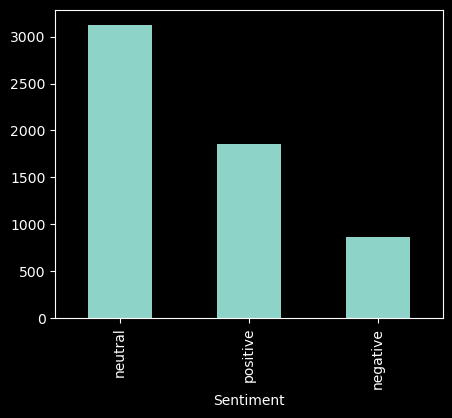

Sentiment
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64


In [3]:
plt.style.use('dark_background')
df['Sentiment'].value_counts().plot(kind='bar', figsize=(5,4))
plt.show()
print(df['Sentiment'].value_counts())

→ Data is not balanced

## 2.0 Data Preprocessing

In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

#nltk.download('punkt_tab')
#nltk.download('stopwords')

### 2.1 Data Cleaning

In [5]:
#Load stop words and lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def text_processing(text):
    #Convert text to lowercase
    text = text.lower()
    
    #Remove new line characters
    text = re.sub(r'\n', ' ', text)
    
    #Remove punctuation (except financial symbols like $)
    text = re.sub(f"[{string.punctuation}]", "", text)
    
    #Remove multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    #Tokenize and remove stop words (OPTIONAL later: Keep stop words for SVM)
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    
    #Lemmatization (use only one method)
    text = ' '.join([lemmatizer.lemmatize(word) for word in words])

    return text

#Apply the text processing function
data_copy = df.copy()
data_copy['Sentence'] = data_copy['Sentence'].apply(text_processing)

In [7]:
#Encode sentiment labels into numeric values
le = LabelEncoder()
data_copy['Sentiment'] = le.fit_transform(data_copy['Sentiment'])

#Store processed data in new dataframe
processed_data = pd.DataFrame({
    'Sentence': data_copy['Sentence'],
    'Sentiment': data_copy['Sentiment']
})

In [9]:
processed_data.head()

,Sentence,Sentiment
0,geosolutions technology leverage benefon gps s...,2
1,esi low 150 250 bk real possibility,0
2,last quarter 2010 componenta net sale doubled ...,2
3,according finnishrussian chamber commerce majo...,1
4,swedish buyout firm sold remaining 224 percent...,1


### 2.2 Data Resampling

In [11]:
#Split BEFORE resampling to prevent data leakage
train_data, test_data = train_test_split(
    processed_data, test_size=0.3, random_state=42, stratify=processed_data['Sentiment']
)

#Separate classes in the train set
df_neutral = train_data[train_data['Sentiment'] == 1]  
df_negative = train_data[train_data['Sentiment'] == 0]  
df_positive = train_data[train_data['Sentiment'] == 2]  

#Upsample minority classes to match the Neutral count
df_negative_upsampled = resample(df_negative, replace=True, n_samples=len(df_neutral), random_state=42)
df_positive_upsampled = resample(df_positive, replace=True, n_samples=len(df_neutral), random_state=42)

#Combine balanced training data
train_data_balanced = pd.concat([df_negative_upsampled, df_neutral, df_positive_upsampled])

#Output dataset distributions
print("Balanced Training Data:\n", train_data_balanced['Sentiment'].value_counts())
print("Unchanged Test Data:\n", test_data['Sentiment'].value_counts())

Balanced Training Data:
 Sentiment
0    2191
1    2191
2    2191
Name: count, dtype: int64
Unchanged Test Data:
 Sentiment
1    939
2    556
0    258
Name: count, dtype: int64


The dataset is imbalanced, with significantly fewer negative sentiment examples compared to neutral and positive ones. To address this, we upsample the minority classes (negative and positive) to match the majority class (neutral). This ensures a more balanced training set, reducing bias in the model and improving classification performance.

## 3.0 Traditional ML Models (Classifier models)

In [146]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import StratifiedKFold, GridSearchCV

### 3.1 Naive Bayes model with CountVectorizer (Bag-of-Words)

In [13]:
#Convert text data into numerical vectors using CountVectorizer
cv = CountVectorizer(max_features=1500)

#Transform text data
X_train = cv.fit_transform(train_data_balanced['Sentence']).toarray()
X_test = cv.transform(test_data['Sentence']).toarray()

#Labels (already encoded in Step 2.1)
y_train = train_data_balanced['Sentiment'].values
y_test = test_data['Sentiment'].values

#Model fitting with Naive Bayes Classifier
classifier = MultinomialNB()  #Using MultinomialNB instead of GaussianNB
classifier.fit(X_train, y_train)

#Model Evaluation
y_pred = classifier.predict(X_test)

#Compute confusion matrix and accuracy
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Confusion Matrix:\n", cm)
print("\nNaive Bayes Accuracy:", accuracy)
print()
print(classification_report(y_test, y_pred))

Confusion Matrix:
 [[144  68  46]
 [188 626 125]
 [126 138 292]]

Naive Bayes Accuracy: 0.6058185966913862

              precision    recall  f1-score   support

           0       0.31      0.56      0.40       258
           1       0.75      0.67      0.71       939
           2       0.63      0.53      0.57       556

    accuracy                           0.61      1753
   macro avg       0.57      0.58      0.56      1753
weighted avg       0.65      0.61      0.62      1753



The Naive Bayes model with a CountVectorizer (Bag-of-Words) representation achieved an accuracy of 60.58% on the test set. This means that approximately 60.58% of financial sentences were correctly classified into Positive, Neutral, or Negative sentiment categories. While this is significantly better than random guessing (33.3% for three classes), there is still room for improvement.

Analysis of the Confusion Matrix and F1-scores reveals a strong bias towards the "Neutral" class.

- Best performance on Neutral (F1-score: 71%), likely due to heavy upsampling of the Positive and Negative classes to create a balanced training set.
- Largest misclassification: Neutral → Negative (188 instances), suggesting that Neutral samples contain words that overlap with Negative sentiment under the Bag-of-Words assumption.
- Relatively lower performance on Negative (F1-score: 40%), indicating difficulty in differentiating between Negative and Neutral statements.

These results highlight the limitations of the Naive Bayes model when applied to a simple Bag-of-Words representation, as it assumes word independence and does not capture word order or context. Future improvements could include TF-IDF weighting, alternative classifiers (e.g., SVM, Random Forest), or contextual embeddings (BERT) to improve sentiment separation.

NB selection:
- GaussianNB: assumes features follow normal (Gaussian) distribution → best for continuous/numeric data, e.g. BERT embeddings, word vectors, stock prices, or any numerical dataset
- MultinomialNB: assumes features represent frequencies (e.g., discrete word counts, TF-IDF scores) → best for categorical/count data

### 3.2 Naive Bayes model with TF-IDF

In [17]:
#Convert text data into numerical vectors using TF-IDF
tfidf = TfidfVectorizer(max_features=1500)  # Limit features for efficiency

#Transform text data
X_train = tfidf.fit_transform(train_data_balanced['Sentence']).toarray()
X_test = tfidf.transform(test_data['Sentence']).toarray()

#Labels (already encoded in Step 2.1)
y_train = train_data_balanced['Sentiment'].values
y_test = test_data['Sentiment'].values

#Model fitting with Naive Bayes
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

#Model evaluation
y_pred = classifier.predict(X_test)

#Compute confusion matrix and accuracy
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Confusion Matrix:\n", cm)
print("\nNaive Bayes Accuracy:", accuracy)
print()
print(classification_report(y_test, y_pred))

Confusion Matrix:
 [[141  67  50]
 [186 637 116]
 [118 141 297]]

Naive Bayes Accuracy: 0.6132344552196235

              precision    recall  f1-score   support

           0       0.32      0.55      0.40       258
           1       0.75      0.68      0.71       939
           2       0.64      0.53      0.58       556

    accuracy                           0.61      1753
   macro avg       0.57      0.59      0.57      1753
weighted avg       0.65      0.61      0.63      1753



The Naive Bayes model with TF-IDF achieved a slightly improved accuracy of 61.32% compared to the CountVectorizer approach (60.58%), with minor gains across most metrics. While F1-score for the Positive class increased slightly, the model still favors Neutral predictions, indicating that TF-IDF alone does not fully resolve this bias.

### 3.3 Logistic Regression with TF-IDF

In [148]:
#Convert text data into numerical vectors using TF-IDF
tfidf = TfidfVectorizer(max_features=1500)  # Limit features for efficiency

#Transform text data
X_train = tfidf.fit_transform(train_data_balanced['Sentence']).toarray()
X_test = tfidf.transform(test_data['Sentence']).toarray()

#Labels (already encoded in Step 2.1)
y_train = train_data_balanced['Sentiment'].values
y_test = test_data['Sentiment'].values

#Model fitting with Logistic Regression
classifier = LogisticRegression(max_iter=1000, solver='lbfgs')  
classifier.fit(X_train, y_train)

#Model evaluation
y_pred = classifier.predict(X_test)

#Compute confusion matrix and accuracy
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Confusion Matrix:\n", cm)
print("\nLogistic Regression Accuracy:", accuracy)
print()
print(classification_report(y_test, y_pred))

Confusion Matrix:
 [[132  79  47]
 [158 673 108]
 [ 64 122 370]]

Logistic Regression Accuracy: 0.6702795208214489

              precision    recall  f1-score   support

           0       0.37      0.51      0.43       258
           1       0.77      0.72      0.74       939
           2       0.70      0.67      0.68       556

    accuracy                           0.67      1753
   macro avg       0.62      0.63      0.62      1753
weighted avg       0.69      0.67      0.68      1753



Logistic Regression outperformed Naive Bayes, achieving 67.03% accuracy compared to 61.32% for Naive Bayes.
ey Differences:

- Higher F1-scores across all classes, with the biggest improvement in the neutral class (0.71 → 0.74) and positive class (0.58 → 0.68).
- Better overall balance, indicated by a higher macro F1-score (0.57 → 0.62).
- Fewer misclassifications of positive and neutral sentences, suggesting that Logistic Regression handles nuanced text representations better than Naive Bayes.

Interpretation

Logistic Regression is often more flexible than Naive Bayes, which assumes feature independence - an assumption that does not always hold in text data. The results confirm that Logistic Regression is a stronger baseline when using TF-IDF for sentiment classification.

### 3.4 SVM with a TF-IDF

In [21]:
#Convert text data into numerical vectors using TF-IDF
tfidf = TfidfVectorizer(max_features=1500)  # Limit features for efficiency

#Transform text data
X_train = tfidf.fit_transform(train_data_balanced['Sentence']).toarray()
X_test = tfidf.transform(test_data['Sentence']).toarray()

#Labels (already encoded in Step 2.1)
y_train = train_data_balanced['Sentiment'].values
y_test = test_data['Sentiment'].values

#Model fitting with SVM
classifier = SVC(kernel='linear', C=1.0)  #Using a linear SVM for text classification
classifier.fit(X_train, y_train)

#Model evaluation
y_pred = classifier.predict(X_test)

#Compute confusion matrix and accuracy
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Confusion Matrix:\n", cm)
print("\nSVM Accuracy:", accuracy)
print()
print(classification_report(y_test, y_pred))

Confusion Matrix:
 [[138  72  48]
 [192 625 122]
 [ 96 127 333]]

SVM Accuracy: 0.6252139189960069

              precision    recall  f1-score   support

           0       0.32      0.53      0.40       258
           1       0.76      0.67      0.71       939
           2       0.66      0.60      0.63       556

    accuracy                           0.63      1753
   macro avg       0.58      0.60      0.58      1753
weighted avg       0.66      0.63      0.64      1753



The SVM model with TF-IDF achieved an accuracy of 62.52%, showing a slight improvement over the Naive Bayes model with TF-IDF (61.32%) and CountVectorizer (60.58%), but still lags behind Logistic Regression (3.3).
Key Observations:

- SVM improves upon Naive Bayes, particularly in Positive sentiment detection (F1-score: 0.63 vs. 0.58 for Naive Bayes).
- Neutral class remains dominant (F1-score: 0.71, similar to Naive Bayes) → The model still leans toward Neutral classifications.
- Negative class still struggles (F1-score: 0.40, similar to Naive Bayes) → Many Negative sentences are misclassified.

What This Means:

- SVM provides a slight edge over Naive Bayes, especially in capturing Positive sentiment better.
- However, the model still has difficulty distinguishing Negative from Neutral.
- TF-IDF combined with SVM performs better than Naive Bayes, but bias toward Neutral persists.

→ Logistic Regression with TF-IDF achieved the highest accuracy at 67.03%, outperforming both SVM (62.52%) and Naive Bayes (61.32%).
- Logistic Regression remains the best baseline model with TF-IDF, reinforcing its effectiveness for text classification tasks.
- SVM shows marginal improvement over Naive Bayes but is not the optimal choice.

### 3.5 Check: SVM with TF-IDF and keeping stop words

SVM could benefit from retaining stopwords because it learns from word distributions rather than probabilities:
- Each word (or n-gram) becomes a feature, and SVM finds a hyperplane that best separates the sentiment classes.
- Stopwords can help define context, even if they do not carry much meaning alone.
→ Removing stopwords may discard useful patterns that improve classification.
- E.g. "Stock prices seem to rise" (Positive) vs. "Stock prices don't seem to rise" (Negative) → If "don't" (a stopword) is removed, both sentences become "Stock prices seem to rise" which can distort sentiment classification

In [23]:
#Modify only the text processing function to KEEP stop words
def text_processing_keep_stopwords(text):
    #Convert text to lowercase
    text = text.lower()
    
    #Remove new line characters
    text = re.sub(r'\n', ' ', text)
    
    #Remove punctuation (except financial symbols like $)
    text = re.sub(f"[{string.punctuation}]", "", text)
    
    #Remove multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    #Tokenization (keeping stop words)
    words = word_tokenize(text)
    
    #Lemmatization
    text = ' '.join([lemmatizer.lemmatize(word) for word in words])

    return text

#Apply updated function
data_copy = df.copy()
data_copy['Sentence'] = data_copy['Sentence'].apply(text_processing_keep_stopwords)

#Encode sentiment labels into numeric values
le = LabelEncoder()
data_copy['Sentiment'] = le.fit_transform(data_copy['Sentiment'])

#Store processed data in a new DataFrame
processed_data = pd.DataFrame({
    'Sentence': data_copy['Sentence'],
    'Sentiment': data_copy['Sentiment']
})

#Split BEFORE resampling to prevent data leakage
train_data, test_data = train_test_split(
    processed_data, test_size=0.3, random_state=42, stratify=processed_data['Sentiment']
)

#Separate classes in the train set
df_neutral = train_data[train_data['Sentiment'] == 1]  
df_negative = train_data[train_data['Sentiment'] == 0]  
df_positive = train_data[train_data['Sentiment'] == 2]  

#Upsample minority classes to match the Neutral count
df_negative_upsampled = resample(df_negative, replace=True, n_samples=len(df_neutral), random_state=42)
df_positive_upsampled = resample(df_positive, replace=True, n_samples=len(df_neutral), random_state=42)

#Combine balanced training data
train_data_balanced = pd.concat([df_negative_upsampled, df_neutral, df_positive_upsampled])

#Output dataset distributions
print("Balanced Training Data:\n", train_data_balanced['Sentiment'].value_counts())
print("Unchanged Test Data:\n", test_data['Sentiment'].value_counts())

#Convert text data into numerical vectors using TF-IDF
tfidf = TfidfVectorizer(max_features=1500)  #Limit features for efficiency

#Transform text data
X_train = tfidf.fit_transform(train_data_balanced['Sentence']).toarray()
X_test = tfidf.transform(test_data['Sentence']).toarray()

#Labels (already encoded in Step 2.1)
y_train = train_data_balanced['Sentiment'].values
y_test = test_data['Sentiment'].values

#Model fitting with SVM
classifier = SVC(kernel='linear', C=1.0)  #Using linear SVM for text classification
classifier.fit(X_train, y_train)

#Model evaluation
y_pred = classifier.predict(X_test)

#Compute confusion matrix and accuracy
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Confusion Matrix:\n", cm)
print("\nSVM Accuracy:", accuracy)
print()
print(classification_report(y_test, y_pred))

Balanced Training Data:
 Sentiment
0    2191
1    2191
2    2191
Name: count, dtype: int64
Unchanged Test Data:
 Sentiment
1    939
2    556
0    258
Name: count, dtype: int64
Confusion Matrix:
 [[147  66  45]
 [177 660 102]
 [ 74 123 359]]

SVM Accuracy: 0.6651454649172847

              precision    recall  f1-score   support

           0       0.37      0.57      0.45       258
           1       0.78      0.70      0.74       939
           2       0.71      0.65      0.68       556

    accuracy                           0.67      1753
   macro avg       0.62      0.64      0.62      1753
weighted avg       0.70      0.67      0.68      1753



After reintroducing stop words in preprocessing, the SVM model with TF-IDF achieved an accuracy of 66.51%, which is a noticeable improvement over the previous 62.52% accuracy without stop words.
Key Differences compared to the previous SVM Model (without stop words)

- Overall accuracy increased from 62.52% to 66.51%, suggesting a more effective classification.
- F1-scores improved across all three classes, particularly:
    - Negative class (F1-score: 0.45 → up from 0.40)
    - Neutral class (F1-score: 0.74 → up from 0.71)
    - Positive class (F1-score: 0.68 → up from 0.63)
- More balanced precision and recall, meaning the model not only predicts each class more accurately but also captures them better when they occur.

### 3.5 SVM with BERT embeddings (keeping stop words)

In [161]:
#Reset index to avoid KeyError
train_data_balanced = train_data_balanced.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

#Remove NaN values from the Sentence column
train_data_balanced = train_data_balanced.dropna(subset=['Sentence'])
test_data = test_data.dropna(subset=['Sentence'])

#Load pre-trained BERT model
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

#Convert sentences into BERT embeddings
X_train = bert_model.encode(train_data_balanced['Sentence'].tolist(), convert_to_numpy=True)
X_test = bert_model.encode(test_data['Sentence'].tolist(), convert_to_numpy=True)

#Labels (already encoded in Step 2.1)
y_train = train_data_balanced['Sentiment'].values
y_test = test_data['Sentiment'].values

#Train SVM with BERT embeddings
classifier = SVC(kernel='linear', C=1.0)
classifier.fit(X_train, y_train)

#Model evaluation
y_pred = classifier.predict(X_test)

#Compute confusion matrix and accuracy
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Confusion Matrix:\n", cm)
print("\nSVM Accuracy with BERT:", accuracy)
print()
print(classification_report(y_test, y_pred))

Confusion Matrix:
 [[193  32  33]
 [200 604 135]
 [ 81 102 373]]

SVM Accuracy with BERT: 0.6674272675413577

              precision    recall  f1-score   support

           0       0.41      0.75      0.53       258
           1       0.82      0.64      0.72       939
           2       0.69      0.67      0.68       556

    accuracy                           0.67      1753
   macro avg       0.64      0.69      0.64      1753
weighted avg       0.72      0.67      0.68      1753



The SVM model with BERT embeddings achieved an accuracy of 66.74%, showing a slight improvement over SVM with TF-IDF (66.51%).

Key Observations Compared to previous models:

- Best performance on the Negative class so far (F1-score increased from 0.45 to 0.53) → BERT better captures contextual meaning for negative sentiment.
- Neutral class recall dropped slightly (0.70 → 0.64) → BERT embeddings introduce more balance across classes.
- Positive class remains stable (F1-score: 0.68 → 0.68).
- Macro F1-score increased (0.62 → 0.64), showing better overall balance.

Why did performance improve?

- BERT embeddings capture deeper sentence meaning compared to TF-IDF’s word frequency-based approach.
- Fixing indexing and NaN-related issues did not improve the model itself, but it ensured all sentences were properly encoded, avoiding missing or distorted data.

SVM with BERT embeddings currently provides the best balanced results.
- Further hyperparameter tuning on SMV (adjusting C-value) could refine performance.

### 3.6 Logistic Regression with BERT embeddings

In [189]:
#Reset index to avoid KeyError
train_data_balanced = train_data_balanced.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

#Remove NaN values from the Sentence column
train_data_balanced = train_data_balanced.dropna(subset=['Sentence'])
test_data = test_data.dropna(subset=['Sentence'])

#Load pre-trained BERT model
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

#Convert sentences into BERT embeddings
X_train = bert_model.encode(train_data_balanced['Sentence'].tolist(), convert_to_numpy=True)
X_test = bert_model.encode(test_data['Sentence'].tolist(), convert_to_numpy=True)

#Labels (already encoded in Step 2.1)
y_train = train_data_balanced['Sentiment'].values
y_test = test_data['Sentiment'].values

#Train Logistic Regression with BERT embeddings
classifier = LogisticRegression(max_iter=1000, solver='lbfgs')
classifier.fit(X_train, y_train)

#Model evaluation
y_pred = classifier.predict(X_test)

#Compute confusion matrix and accuracy
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Confusion Matrix:\n", cm)
print("\nLogistic Regression Accuracy with BERT:", accuracy)
print()
print(classification_report(y_test, y_pred))

Confusion Matrix:
 [[174  44  40]
 [169 635 135]
 [ 76  90 390]]

Logistic Regression Accuracy with BERT: 0.683970336565887

              precision    recall  f1-score   support

           0       0.42      0.67      0.51       258
           1       0.83      0.68      0.74       939
           2       0.69      0.70      0.70       556

    accuracy                           0.68      1753
   macro avg       0.64      0.68      0.65      1753
weighted avg       0.72      0.68      0.69      1753



Both models used BERT embeddings, but Logistic Regression outperformed SVM, achieving 68.39% accuracy vs. 66.74% for SVM.

Better balance in recall across classes

- Logistic Regression recall for the neutral class (68%) is higher than SVM (64%), meaning it misclassifies fewer neutral sentences.
- The positive class (70% recall) also slightly improved from 67% in SVM.

Minor trade-off in precision for the negative class
SVM classified more negative sentences correctly (75% recall vs. 67%), but Logistic Regression achieves better recall for the other two classes.

Conclusion

✔ Logistic Regression + BERT embeddings is the strongest baseline model so far.
✔ SVM performs well but slightly worse, possibly due to its sensitivity to high-dimensional embeddings.
✔ Using BERT embeddings clearly improves performance over TF-IDF, confirming that contextual representations matter.

### 3.6.1 Logistic Regression with BERT embeddings and k-fold Cross-Validation

In [205]:
#Define the hyperparameter grid
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

#Initialize Logistic Regression model
lr = LogisticRegression(max_iter=1000, solver='lbfgs')

#Set up GridSearchCV with 5-Fold Cross-Validation
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

#Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

#Get the best hyperparameter
best_C = grid_search.best_params_['C']
print("Best C value:", best_C)

#Train the final model with the best C
best_lr = LogisticRegression(C=best_C, max_iter=1000, solver='lbfgs')
best_lr.fit(X_train, y_train)

#Evaluate final model
y_pred = best_lr.predict(X_test)

#Compute confusion matrix and accuracy
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Display results
print("\nConfusion Matrix:\n", cm)
print("\nLogistic Regression Accuracy with BERT & K-Fold CV:", accuracy)
print()
print(classification_report(y_test, y_pred))

Best C value: 100

Confusion Matrix:
 [[145  73  40]
 [170 613 156]
 [ 68 107 381]]

Logistic Regression Accuracy with BERT & K-Fold CV: 0.6497432972047917

              precision    recall  f1-score   support

           0       0.38      0.56      0.45       258
           1       0.77      0.65      0.71       939
           2       0.66      0.69      0.67       556

    accuracy                           0.65      1753
   macro avg       0.60      0.63      0.61      1753
weighted avg       0.68      0.65      0.66      1753



The lower performance of Logistic Regression with K-Fold CV (64.97%) on the upsampled dataset compared to Logistic Regression with BERT embeddings without K-Fold CV (68.40%) can be attributed to the following key factors:

Hyperparameter Selection Effect
- K-Fold CV optimized C = 100, whereas the default model used C = 1.
- A high C value results in lower regularization, making the model more prone to overfitting, which can explain the performance drop on the test set.

Variance in Training Splits
- Even though the dataset was upsampled to be balanced, each fold still introduces slight variations in training distributions due to random partitioning.
- This can lead to a less optimal generalization compared to training on the full dataset at once.

K-Fold vs. Full-Set Training
- Without K-Fold, the model was trained on the entire upsampled dataset, maximizing available training data.
- With K-Fold, the model was trained on 80% of the data per fold, which may reduce the effective learning capacity for certain patterns in the data.

### 3.6.2 Logistic Regression with BERT embeddings and Stratified k-fold Cross-Validation

Expectation: Since the training data was upsampled to ensure equal class distributions across sentiment categories, the standard k-Fold CV and Stratified k-Fold CV should produce identical results. This is because Stratified K-Fold aims to preserve class proportions in each fold, but given the already balanced dataset, both methods effectively create the same splits.

In [171]:
#Define the hyperparameter grid
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

#Initialize Logistic Regression model
lr = LogisticRegression(max_iter=1000, solver='lbfgs')

#Set up Stratified K-Fold Cross-Validation with 5 folds
stratified_kfold = StratifiedKFold(n_splits=5)

#Use GridSearchCV with Stratified K-Fold
grid_search = GridSearchCV(lr, param_grid, cv=stratified_kfold, scoring='accuracy', n_jobs=-1)

#Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

#Get the best hyperparameter
best_C = grid_search.best_params_['C']
print("Best C value:", best_C)

#Train the final model with the best C
best_lr = LogisticRegression(C=best_C, max_iter=1000, solver='lbfgs')
best_lr.fit(X_train, y_train)

#Evaluate the final model
y_pred = best_lr.predict(X_test)

#Compute confusion matrix and accuracy
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("\nConfusion Matrix:\n", cm)
print("\nLogistic Regression Accuracy with BERT & Stratified K-Fold CV:", accuracy)
print()
print(classification_report(y_test, y_pred))

Best C value: 100

Confusion Matrix:
 [[145  73  40]
 [170 613 156]
 [ 68 107 381]]

Logistic Regression Accuracy with BERT & Stratified K-Fold CV: 0.6497432972047917

              precision    recall  f1-score   support

           0       0.38      0.56      0.45       258
           1       0.77      0.65      0.71       939
           2       0.66      0.69      0.67       556

    accuracy                           0.65      1753
   macro avg       0.60      0.63      0.61      1753
weighted avg       0.68      0.65      0.66      1753



### 3.7 Considering other traditional ML models and methods

- Decision Tree (DT) → Works well when patterns are simple but tends to overfit on text data.
- Random Forest (RF) → A collection of Decision Trees, more robust but still struggles with high-dimensional sparse text data.
- Using K-Fold CV on the original (non-upsampled) training dataset would avoid potential bias introduced by synthetic data but would significantly reduce the number of "Negative" class samples in each fold (~480 per training fold in 5-fold CV). This would likely worsen class imbalance issues, leading to poor model generalization, especially for the minority class.

## 4.0 Traditional Deep Learning Models

### 4.1 Recurrent Neural Network (RNN)

In [103]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertForSequenceClassification
import keras_tuner as kt

In [97]:
# Adjusted parameters for dataset
MAX_NB_WORDS = 5000  # Limit vocabulary size
MAX_SEQUENCE_LENGTH = 50  # Max words per sentence (aligned with data)
EMBEDDING_DIM = 100  # Standard embedding size

# Initialize and fit tokenizer (no additional filtering)
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)  # Prevent redundant preprocessing
tokenizer.fit_on_texts(train_data_balanced['Sentence'].values)  # Fit only on training set

# Convert sentences to sequences of numbers
X_train = tokenizer.texts_to_sequences(train_data_balanced['Sentence'].values)
X_test = tokenizer.texts_to_sequences(test_data['Sentence'].values)

# Pad sequences to ensure uniform input shape
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

# One-hot encode labels
Y_train = pd.get_dummies(train_data_balanced['Sentiment']).values
Y_test = pd.get_dummies(test_data['Sentiment']).values

# Display shapes of processed data
print("Vocabulary Size:", min(MAX_NB_WORDS, len(tokenizer.word_index)))
print("Training Data Shape:", X_train.shape)
print("Test Data Shape:", X_test.shape)
print("Label Shape:", Y_train.shape)

Vocabulary Size: 5000
Training Data Shape: (6573, 50)
Test Data Shape: (1753, 50)
Label Shape: (6573, 3)


In [99]:
# Define RNN model
rnn_model = Sequential()
rnn_model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM))  # Removed `input_length`
rnn_model.add(SpatialDropout1D(0.2))  # Prevent overfitting
rnn_model.add(SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2))  # 128 RNN units
rnn_model.add(Dense(3, activation='softmax'))  # 3 output classes

# Compile the model
rnn_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Training parameters
epochs = 10  # Adjust as needed
batch_size = 64  # Consistent batch size

# Train the model and use test data for validation
rnn_history = rnn_model.fit(
    X_train, Y_train, 
    epochs=epochs, 
    batch_size=batch_size,
    validation_data=(X_test, Y_test),  # Use actual test set
    verbose=1
)

# Evaluate on test set
rnn_eval = rnn_model.evaluate(X_test, Y_test)
print("\nRNN Test Loss: {:.4f}".format(rnn_eval[0]))
print("RNN Test Accuracy: {:.4f}".format(rnn_eval[1]))

# Convert model predictions to class labels
y_pred_probs = rnn_model.predict(X_test)  # Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
y_true = np.argmax(Y_test, axis=1)  # Convert one-hot to class labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)

# Compute classification report (precision, recall, F1-score)
print("\nClassification Report:\n", classification_report(y_true, y_pred))

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.3416 - loss: 1.1274 - val_accuracy: 0.2510 - val_loss: 1.1072
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5323 - loss: 1.0009 - val_accuracy: 0.4353 - val_loss: 1.0637
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7322 - loss: 0.7142 - val_accuracy: 0.5014 - val_loss: 1.0722
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8211 - loss: 0.4858 - val_accuracy: 0.5106 - val_loss: 1.1928
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8738 - loss: 0.3650 - val_accuracy: 0.5054 - val_loss: 1.3063
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9068 - loss: 0.2765 - val_accuracy: 0.5197 - val_loss: 1.4120
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9134 - loss: 0.2442 - val_accuracy: 0.5066 - val_loss: 1.5486
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9215 - loss: 0.2185 - val_accu

The results indicate that the Simple RNN struggles to classify financial sentiment effectively, achieving an accuracy of only 49.4% on the test set. This is significantly lower than the performance of traditional ML models like Logistic Regression with BERT embeddings (68.4%) or SVM with BERT embeddings (66.7%).

Overfitting:
- The training accuracy steadily increased to 93.24%, while the test accuracy remained around 48%, suggesting the model is memorizing training data rather than generalizing well.
- The validation loss keeps increasing (from 1.06 to 1.83), which confirms severe overfitting.

Class Imbalance Impact:
- The model performed best on the neutral class (F1-score: 0.61) but struggled with negative sentiment (F1-score: 0.18).
- The misclassification of negative and positive sentiments is substantial, indicating the model is biased toward the majority class.

RNNs Struggle with Financial Text:
- Financial sentiment sentences are short and context-dependent, meaning RNNs might not be the best model choice.
- Unlike BERT-based models, RNNs process text sequentially, which makes them less efficient at capturing complex sentiment patterns.

### 4.2 Long Short-Term Memory (LSTM)

In [238]:
# Define LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM))  # Embedding layer
lstm_model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))  # 128 LSTM units
lstm_model.add(Dense(3, activation='softmax'))  # 3 output classes

# Compile the model
lstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Training parameters
epochs = 10  # Adjust based on performance
batch_size = 64  # Consistent with previous models

# Train the model
lstm_history = lstm_model.fit(
    X_train, Y_train, 
    epochs=epochs, 
    batch_size=batch_size,
    validation_data=(X_test, Y_test), 
    verbose=1
)

# Evaluate on test set
lstm_eval = lstm_model.evaluate(X_test, Y_test)
print("\nLSTM Test Loss: {:.4f}".format(lstm_eval[0]))
print("LSTM Test Accuracy: {:.4f}".format(lstm_eval[1]))

# Convert model predictions to class labels
y_pred_probs = lstm_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(Y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)

# Compute classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred))

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - accuracy: 0.4887 - loss: 1.0150 - val_accuracy: 0.6623 - val_loss: 0.7923
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.8517 - loss: 0.4032 - val_accuracy: 0.6646 - val_loss: 0.8479
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.9177 - loss: 0.2574 - val_accuracy: 0.6777 - val_loss: 0.8903
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.9342 - loss: 0.1914 - val_accuracy: 0.6703 - val_loss: 0.9660
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.9424 - loss: 0.1689 - val_accuracy: 0.6583 - val_loss: 1.1397
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.9493 - loss: 0.1443 - val_accuracy: 0.6669 - val_loss: 1.1847
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.9509 - loss: 0.1354 - val_accuracy: 0.6572 - val_loss: 1.3088
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.9542 - loss: 0.1255 - val_acc

The LSTM model achieved an accuracy of 66.12%, marking a significant improvement over the RNN model (49.4%) and approaching the performance of traditional ML models, however:

Accuracy & Overfitting Analysis
- The training accuracy reached 95.3%, but the test accuracy is only 66.12% → clear overfitting.
- The increasing validation loss across epochs suggests the model memorizes training data but doesn’t generalize well, which is another strong indication of overfitting.
- The test loss (1.416) is significantly higher than the training loss (0.1247), showing the model struggles to generalize.

Stronger Sentiment Prediction:
- The neutral (class 1) category performed best with an F1-score of 73%, maintaining high precision and recall.
- The positive (class 2) sentiment improved, achieving an F1-score of 72%, meaning LSTM effectively captured long-range dependencies in financial text.
- The negative class (class 0) still struggles, with 30% F1-score, suggesting that it is harder to differentiate from the other sentiments.

Key Comparison to Other Models:
- Better than RNN → +17% increase in accuracy, indicating that LSTM’s memory capabilities help with sentiment classification.
- Similar to SVM & Logistic Regression with BERT → Suggests that financial sentiment is more effectively captured using embeddings rather than sequential modeling alone.

### 4.3 Gated Recurrent Units (GRU)

In [249]:
# Define GRU model
gru_model = Sequential()
gru_model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM))  # Embedding layer
gru_model.add(SpatialDropout1D(0.2))  # Dropout for regularization
gru_model.add(GRU(128, dropout=0.2, recurrent_dropout=0.2))  # GRU instead of LSTM
gru_model.add(Dense(3, activation='softmax'))  # Output layer with 3 classes

# Compile the model
gru_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Training parameters
epochs = 10  # Keep consistent with LSTM
batch_size = 64  # Batch size

# Train the model and use test data for validation
gru_history = gru_model.fit(
    X_train, Y_train, 
    epochs=epochs, 
    batch_size=batch_size,
    validation_data=(X_test, Y_test),  # Use actual test set
    verbose=1
)

# Evaluate on test set
gru_eval = gru_model.evaluate(X_test, Y_test)
print("\nGRU Test Loss: {:.4f}".format(gru_eval[0]))
print("GRU Test Accuracy: {:.4f}".format(gru_eval[1]))

# Convert model predictions to class labels
y_pred_probs = gru_model.predict(X_test)  # Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
y_true = np.argmax(Y_test, axis=1)  # Convert one-hot to class labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)

# Compute classification report (precision, recall, F1-score)
print("\nClassification Report:\n", classification_report(y_true, y_pred))

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - accuracy: 0.4506 - loss: 1.0387 - val_accuracy: 0.6161 - val_loss: 0.8583
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8241 - loss: 0.4705 - val_accuracy: 0.6463 - val_loss: 0.9016
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.9009 - loss: 0.2852 - val_accuracy: 0.6440 - val_loss: 0.9764
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.9301 - loss: 0.2086 - val_accuracy: 0.6520 - val_loss: 1.0415
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.9291 - loss: 0.1899 - val_accuracy: 0.6686 - val_loss: 1.1629
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9432 - loss: 0.1461 - val_accuracy: 0.6589 - val_loss: 1.2634
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9504 - loss: 0.1323 - val_accuracy: 0.6663 - val_loss: 1.4252
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.9451 - loss: 0.1459 - val_acc

Accuracy & Overfitting Analysis
- The training accuracy reached 95.66%, but the test accuracy is only 64.8% → clear overfitting.
- The increasing validation loss across epochs suggests the model memorizes training data but doesn’t generalize well, which is another strong indication of overfitting.
- The test loss (1.5843) is significantly higher than the training loss (0.1223), showing the model struggles to generalize.

### Intermediate Conclusion

Given the nature of our dataset (small + upscaled), the overfitting of deep learning models is expected.

Small Dataset + Deep Learning = Overfitting Risk
- Deep learning models, especially RNN, LSTM, and GRU, require large datasets to generalize well.
- 5000 sentences are relatively small for training a complex deep learning model.
- The models are likely memorizing patterns rather than learning general rules.

Upsampling Causes Redundant Information
- We upscaled the minority classes (Positive & Negative) to balance the dataset.
- This creates many duplicate or very similar data points, which makes it easier for deep learning models to memorize rather than truly generalize.
- This is less of an issue in traditional ML models (like Logistic Regression, SVM) but becomes problematic for deep learning models.

Lack of Variability in the Dataset (sentences in financial news/social media are short & repetitive):
- Less unique patterns for deep learning models to learn from.
- Higher risk of memorization (overfitting) rather than generalization.

What can be done to reduce Overfitting?

- Use More Data (if possible) → More training examples would allow the model to generalize better.
- Apply Stronger Regularization (Dropout, L2 penalties, batch normalization).
- Reduce Model Complexity (e.g., fewer LSTM/GRU units instead of 128, use smaller embedding layers).
- Early Stopping → Stop training when validation loss starts increasing.
- Augment Data (if applicable) → Introduce synthetic variation (paraphrasing, adding noise).
- Use Simpler Models → Given our dataset, Logistic Regression + BERT embeddings performed best, which suggests a deep model might not be necessary.

### 4.4 Long Short-Term Memory (LSTM) with BERT embeddings

In [101]:
# Load pre-trained BERT model
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Convert sentences into BERT embeddings
X_train = bert_model.encode(train_data_balanced['Sentence'].tolist(), convert_to_numpy=True)
X_test = bert_model.encode(test_data['Sentence'].tolist(), convert_to_numpy=True)

# Reshape input to fit LSTM (adding a time step dimension)
X_train = np.expand_dims(X_train, axis=1)  # Shape: (num_samples, time_steps, embedding_dim)
X_test = np.expand_dims(X_test, axis=1)

# Define LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, input_shape=(X_train.shape[1], X_train.shape[2])))  # Input shape adjusted
lstm_model.add(Dense(3, activation='softmax'))  # 3 output classes

# Compile the model
lstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Training parameters
epochs = 10  # Adjust based on performance
batch_size = 64  # Consistent with previous models

# Train the model
lstm_history = lstm_model.fit(
    X_train, Y_train, 
    epochs=epochs, 
    batch_size=batch_size,
    validation_data=(X_test, Y_test), 
    verbose=1
)

# Evaluate on test set
lstm_eval = lstm_model.evaluate(X_test, Y_test)
print("\nLSTM Test Loss: {:.4f}".format(lstm_eval[0]))
print("LSTM Test Accuracy: {:.4f}".format(lstm_eval[1]))

# Convert model predictions to class labels
y_pred_probs = lstm_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(Y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)

# Compute classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred))

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5417 - loss: 1.0407 - val_accuracy: 0.6515 - val_loss: 0.8448
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6940 - loss: 0.7542 - val_accuracy: 0.6594 - val_loss: 0.7725
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7246 - loss: 0.6644 - val_accuracy: 0.6560 - val_loss: 0.7815
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7399 - loss: 0.6273 - val_accuracy: 0.6720 - val_loss: 0.7273
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7346 - loss: 0.6300 - val_accuracy: 0.6748 - val_loss: 0.7334
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7455 - loss: 0.6019 - val_accuracy: 0.6823 - val_loss: 0.7046
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7362 - loss: 0.6206 - val_accuracy: 0.6834 - val_loss: 0.7139
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7477 - loss: 0.5900 - val_accuracy: 0

BERT embeddings improved overall performance, particularly for the Negative class, which struggled previously.
- Test loss decreased significantly (1.4160 → 0.696), indicating better generalization.
- Higher precision and recall for all classes, suggesting that BERT embeddings provide richer semantic understanding.
- Fewer extreme misclassifications compared to the traditional embedding approach.

LSTM with BERT embeddings clearly outperforms the traditional embedding approach. The Negative class saw the biggest improvement, which is critical given its previous misclassification rate. The overall F1-score distribution is more balanced, and the test loss indicates better convergence.

### 4.5 Hyperparameter Tuning for LSTM Model with BERT embeddings using Keras Tuner

In [273]:
# Define search function for the LSTM model with tunable hyperparameters
def build_lstm_model(hp):
    model = Sequential()
    
    # Add LSTM layer with tunable number of units
    model.add(LSTM(
        units=hp.Int('units', min_value=64, max_value=256, step=32),  
        dropout=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1),  
        recurrent_dropout=hp.Float('recurrent_dropout', min_value=0.1, max_value=0.5, step=0.1),
        input_shape=(X_train.shape[1], X_train.shape[2])  # Shape of BERT embeddings
    ))

    # Dense output layer
    model.add(Dense(3, activation='softmax'))

    # Compile the model with tunable learning rate
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

#Set up Keras tuner search
from keras_tuner import RandomSearch

# Set up tuner
tuner = RandomSearch(
    build_lstm_model,
    objective='val_accuracy',  # Optimize for validation accuracy
    max_trials=10,  # Number of different hyperparameter sets to try
    executions_per_trial=2,  # Runs each trial twice to reduce variance
    directory='tuner_results',
    project_name='lstm_bert_tuning'
)


# Run hyperparameter search
tuner.search(
    X_train, Y_train,
    epochs=10,
    batch_size=64,  # You can also tune batch size if needed
    validation_split=0.2
)

# Get the best hyperparameter combination
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best LSTM units: {best_hps.get('units')}
Best Dropout rate: {best_hps.get('dropout')}
Best Recurrent Dropout rate: {best_hps.get('recurrent_dropout')}
Best Learning Rate: {best_hps.get('learning_rate')}
""")

# Build the best model
best_model = tuner.hypermodel.build(best_hps)

# Train the model with optimal hyperparameters
history = best_model.fit(
    X_train, Y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, Y_test),
    verbose=1
)

# Evaluate on test set
test_loss, test_accuracy = best_model.evaluate(X_test, Y_test)
print("\nTuned LSTM Test Loss: {:.4f}".format(test_loss))
print("Tuned LSTM Test Accuracy: {:.4f}".format(test_accuracy))

Trial 10 Complete [00h 00m 25s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.6117870807647705
Total elapsed time: 00h 04m 42s

Best LSTM units: 224
Best Dropout rate: 0.2
Best Recurrent Dropout rate: 0.5
Best Learning Rate: 0.001

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5615 - loss: 1.0189 - val_accuracy: 0.6526 - val_loss: 0.8214
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6952 - loss: 0.7229 - val_accuracy: 0.6640 - val_loss: 0.7770
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7186 - loss: 0.6650 - val_accuracy: 0.6691 - val_loss: 0.7622
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7415 - loss: 0.6296 - val_accuracy: 0.6743 - val_loss: 0.7334
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7431 - loss: 0.6179 - val_accuracy: 0.6868 - val_loss: 0.6971
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7389 - loss: 0.5999 - val_accuracy: 0.6680 - val_loss: 

The hyperparameter tuning process for the LSTM model, which aimed to optimize dropout rates, recurrent dropout, LSTM units, and learning rate, resulted in a slight decline in test accuracy from 68.85% to 67.43%.

This suggests that the default hyperparameters in the original model were already well-suited to the dataset, and further tuning did not yield improvements. Possible explanations include:

1. Limited Dataset Size: With only 5000 financial sentences divided into three sentiment classes, tuning may have led to overfitting on the validation set rather than generalizing better to unseen data.
2. Randomness in Optimization: Hyperparameter tuning introduces variability, and the tuning process might have converged on a suboptimal set of hyperparameters despite multiple trials.
3. Regularization Constraints: The tuned model applied a higher recurrent dropout (0.5), which may have reduced the model's ability to retain long-term dependencies in the financial text.

## 5.0 Modern Deep Learning Models (Transformers)

### 5.1 Fine-tuning BERT model (Bidirectional Encoder Representations from Transformers)

In [89]:
#Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#Tokenize input sentences
X_train_encodings = tokenizer(list(train_data_balanced['Sentence']), truncation=True, padding=True, max_length=50, return_tensors="tf")
X_test_encodings = tokenizer(list(test_data['Sentence']), truncation=True, padding=True, max_length=50, return_tensors="tf")

#Convert labels to tensors
Y_train = tf.convert_to_tensor(train_data_balanced['Sentiment'])
Y_test = tf.convert_to_tensor(test_data['Sentiment'])

#Load pre-trained BERT model
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

#Compile the model
bert_model.compile(optimizer= AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01), 
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                   metrics=['accuracy'])

#Train BERT on dataset
bert_model.fit(
    X_train_encodings.data, Y_train, 
    validation_data=(X_test_encodings.data, Y_test), 
    epochs=3, batch_size=16
)

#Evaluate on test set
test_loss, test_accuracy = bert_model.evaluate(X_test_encodings.data, Y_test)

print("\nBERT Test Loss: {:.4f}".format(test_loss))
print("BERT Test Accuracy: {:.4f}".format(test_accuracy))

#Convert model predictions to class labels
y_pred_probs = bert_model.predict(X_test_encodings.data).logits
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = Y_test.numpy()

#Compute confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_true, y_pred))

Epoch 1/3
411/411 [==============================] - 1577s 4s/step - loss: 0.5821 - accuracy: 0.7499 - val_loss: 0.5321 - val_accuracy: 0.7735
Epoch 2/3
411/411 [==============================] - 1583s 4s/step - loss: 0.2579 - accuracy: 0.9049 - val_loss: 0.5943 - val_accuracy: 0.7718
Epoch 3/3
55/55 [==============================] - 94s 2s/step - loss: 0.6527 - accuracy: 0.7644

BERT Test Loss: 0.6527
BERT Test Accuracy: 0.7644
55/55 [==============================] - 105s 2s/step

Confusion Matrix:
 [[186  53  19]
 [175 681  83]
 [ 43  40 473]]

Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.72      0.56       258
           1       0.88      0.73      0.80       939
           2       0.82      0.85      0.84       556

    accuracy                           0.76      1753
   macro avg       0.72      0.77      0.73      1753
weighted avg       0.80      0.76      0.77      1753



Final Model Performance & Conclusion

The fine-tuned BERT model achieved a test accuracy of 76.44%, making it the best-performing model across all tested approaches. It significantly outperformed traditional ML models (SVM, Logistic Regression) as well as deep learning models (LSTM, GRU, RNN).

Key Takeaways:

- Best Overall Performance
    - Highest accuracy (76.44%) compared to LSTM with BERT embeddings (68.85%).
    - Strongest precision, recall, and F1-score across all sentiment classes.
    - Particularly effective at identifying positive and neutral sentiment, achieving F1-scores above 80%.

- Pretraining Advantage & Transfer Learning
    - Unlike LSTM and GRU models, which learn representations from scratch, BERT leverages contextual embeddings from extensive pretraining.
    - This leads to better generalization and higher recall for all sentiment classes.
    - Transformer-based models capture relationships between words more effectively than TF-IDF or sequential models like LSTMs.

Challenges & Considerations

- Potential Overfitting
    - The model’s training accuracy increased rapidly (93.18%), while validation accuracy plateaued at ~77%, suggesting some degree of overfitting.
    - Future improvements: Regularization techniques like dropout, early stopping, or learning rate adjustments could be tested.

- Computational Cost
    - Training was significantly slower than other models (~26 minutes per epoch) due to the complexity of fine-tuning BERT.
    - Fine-tuning was conducted locally on a 2016 Dell XPS 15 (i7-6700HQ, GTX 960M, 16GB RAM), which extended training time.
    - Scalable cloud-based solutions (e.g., Google Colab, AWS, Kaggle TPUs) would be recommended for real-world deployment.

- Computational Trade-Offs:
    - While BERT fine-tuning produced the best results, it required significantly more computational resources and time. Alternative models like Logistic Regression with BERT embeddings (68.39%) provide competitive performance at a fraction of the training cost.
    - Practical Implications: For real-world applications, the choice between BERT fine-tuning and lighter models depends on computational constraints. If resources are limited, a model like Logistic Regression with BERT embeddings can be a viable alternative while maintaining reasonable accuracy.

- Comparison to LSTM with BERT Embeddings
    - Fine-tuning BERT outperformed using BERT embeddings in an LSTM model (76.44% vs. 68.85% accuracy).
    - This confirms that directly fine-tuning BERT yields superior results over simply using its embeddings with another classifier.

Final Conclusion

The fine-tuned BERT model is the best-performing model for financial sentiment classification. However, its computational cost is much higher than traditional models, and overfitting could become a concern with further training.
For real-world deployment:
- Fine-tuning strategies (e.g., learning rate adjustments, more data, or additional regularization) should be explored.
- Scalable cloud-based training (TPUs, GPUs) would be preferable for efficiency.
- If computational cost is a constraint, an LSTM with BERT embeddings could be a reasonable alternative.

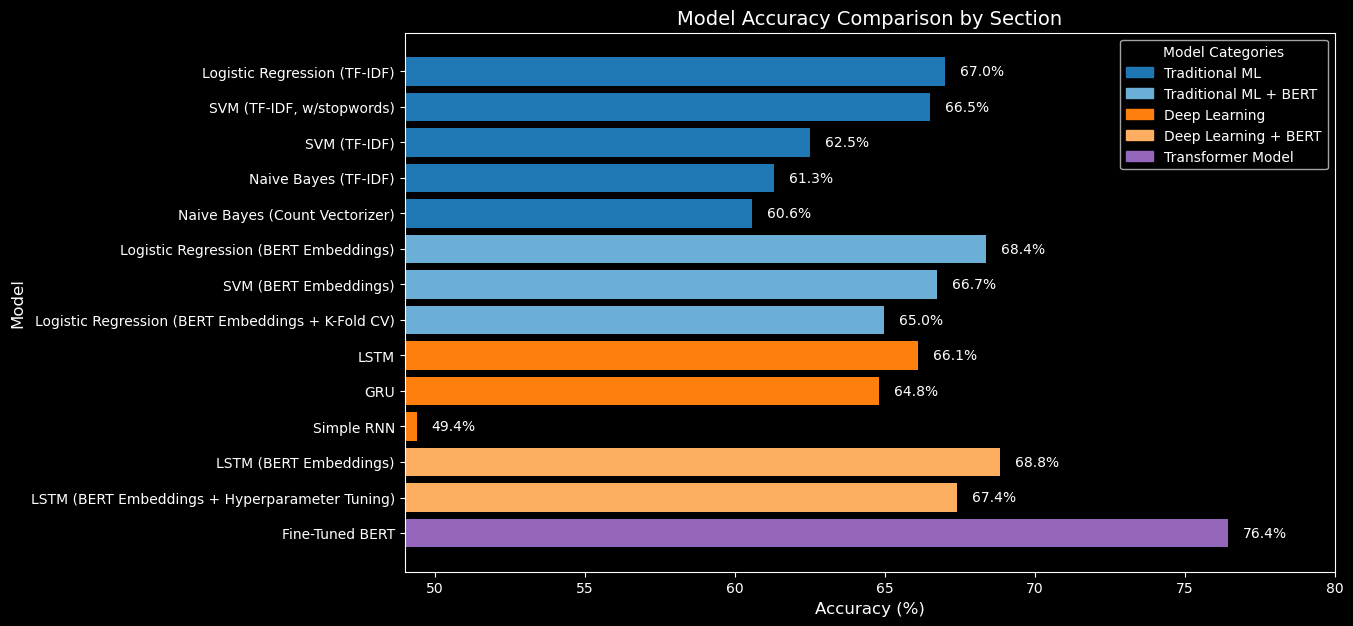

In [228]:
models = [
    ("Naive Bayes (Count Vectorizer)", "Traditional ML", 0.6058),
    ("Naive Bayes (TF-IDF)", "Traditional ML", 0.6132),
    ("Logistic Regression (TF-IDF)", "Traditional ML", 0.6703),
    ("SVM (TF-IDF)", "Traditional ML", 0.6252),
    ("SVM (TF-IDF, w/stopwords)", "Traditional ML", 0.6652),
    
    ("Logistic Regression (BERT Embeddings)", "Traditional ML + BERT", 0.6839),
    ("Logistic Regression (BERT Embeddings + K-Fold CV)", "Traditional ML + BERT", 0.6497),
    ("SVM (BERT Embeddings)", "Traditional ML + BERT", 0.6674),

    ("Simple RNN", "Deep Learning", 0.4940),
    ("GRU", "Deep Learning", 0.6480),
    ("LSTM", "Deep Learning", 0.6612),

    ("LSTM (BERT Embeddings)", "Deep Learning + BERT", 0.6885),
    ("LSTM (BERT Embeddings + Hyperparameter Tuning)", "Deep Learning + BERT", 0.6743),

    ("Fine-Tuned BERT", "Transformer Model", 0.7644)
]

#Convert to structured array for sorting
dtype = [('Model', 'U50'), ('Section', 'U50'), ('Accuracy', 'f4')]
sorted_models = np.array(models, dtype=dtype)

#Define explicit section order
section_order = [
    "Traditional ML",
    "Traditional ML + BERT",
    "Deep Learning",
    "Deep Learning + BERT",
    "Transformer Model"
]

#Sort models first by section, then by accuracy (descending within each section)
sorted_models = sorted(sorted_models, key=lambda x: (section_order.index(x['Section']), -x['Accuracy']))

#Extract sorted names and values
model_names = [m['Model'] for m in sorted_models]
sections = [m['Section'] for m in sorted_models]
accuracies = [m['Accuracy'] * 100 for m in sorted_models]  # Convert to percentage scale

#Define distinct colors for major sections and shades for subcategories
section_colors = {
    "Traditional ML": "#1f77b4",  # Blue
    "Traditional ML + BERT": "#6baed6",  # Lighter Blue
    "Deep Learning": "#ff7f0e",  # Orange
    "Deep Learning + BERT": "#fdae61",  # Lighter Orange
    "Transformer Model": "#9467bd"  # Purple
}
colors = [section_colors[sec] for sec in sections]

#Apply dark mode style
plt.style.use("dark_background")

#Create bar chart
fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.barh(model_names, accuracies, color=colors)

#Add accuracy labels (formatted as percentages)
for bar in bars:
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
            f"{bar.get_width():.1f}%", va='center', fontsize=10, color='white')

#Formatting
ax.set_xlabel("Accuracy (%)", fontsize=12, color='white')
ax.set_ylabel("Model", fontsize=12, color='white')
ax.set_title("Model Accuracy Comparison by Section", fontsize=14, color='white')
ax.set_xlim(49, 80)  # Adjust x-axis limits for better spacing

#Create legend for major sections and place at the top right
handles = [plt.Rectangle((0,0),1,1, color=section_colors[sec]) for sec in section_order]
plt.legend(handles, section_order, title="Model Categories", fontsize=10, loc="upper right")

plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()